In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Prostate Cancer Risk Prediction')

2025/07/28 05:43:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/28 05:43:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/Assisted-Visual-Navigation/Notebooks/mlruns/1', creation_time=1753596264716, experiment_id='1', last_update_time=1753596264716, lifecycle_stage='active', name='Prostate Cancer Risk Prediction', tags={}>

In [3]:
file_path = r'/workspaces/Assisted-Visual-Navigation/Data/raw/synthetic_prostate_cancer_risk.csv'
df = pd.read_csv(file_path)
print(df.columns)
print(df.describe())

Index(['id', 'age', 'bmi', 'smoker', 'alcohol_consumption', 'diet_type',
       'physical_activity_level', 'family_history', 'mental_stress_level',
       'sleep_hours', 'regular_health_checkup', 'prostate_exam_done',
       'risk_level'],
      dtype='object')
                id          age          bmi  sleep_hours
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    500.500000    55.159000    26.003100     6.725500
std     288.819436    14.400107     3.012387     1.320948
min       1.000000    30.000000    17.700000     4.500000
25%     250.750000    43.000000    23.900000     5.600000
50%     500.500000    55.000000    26.000000     6.700000
75%     750.250000    68.000000    28.025000     7.900000
max    1000.000000    80.000000    36.800000     9.000000


In [4]:
print(df.head())
print(df.isnull().sum())
df.dtypes

   id  age   bmi smoker alcohol_consumption diet_type physical_activity_level  \
0   1   39  24.7     No                 NaN     Fatty                Moderate   
1   2   43  25.6    Yes                 NaN     Mixed                    High   
2   3   72  22.4     No            Moderate     Mixed                Moderate   
3   4   60  25.6    Yes                 NaN     Fatty                Moderate   
4   5   51  26.6    Yes                 NaN     Mixed                     Low   

  family_history mental_stress_level  sleep_hours regular_health_checkup  \
0             No                High          5.6                     No   
1             No                High          6.9                    Yes   
2             No                High          7.8                    Yes   
3             No                High          5.6                    Yes   
4             No              Medium          5.9                     No   

  prostate_exam_done risk_level  
0                 No  

id                           int64
age                          int64
bmi                        float64
smoker                      object
alcohol_consumption         object
diet_type                   object
physical_activity_level     object
family_history              object
mental_stress_level         object
sleep_hours                float64
regular_health_checkup      object
prostate_exam_done          object
risk_level                  object
dtype: object

<Figure size 640x480 with 0 Axes>

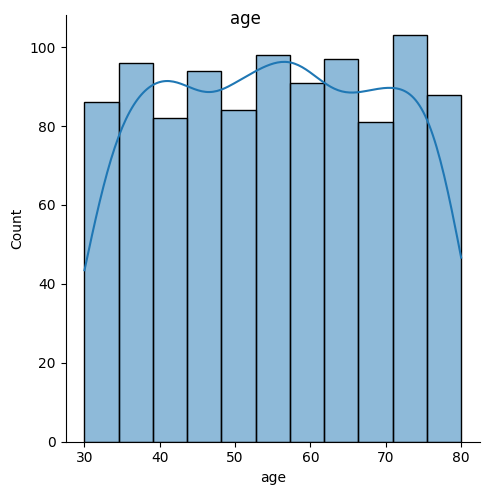

<Figure size 640x480 with 0 Axes>

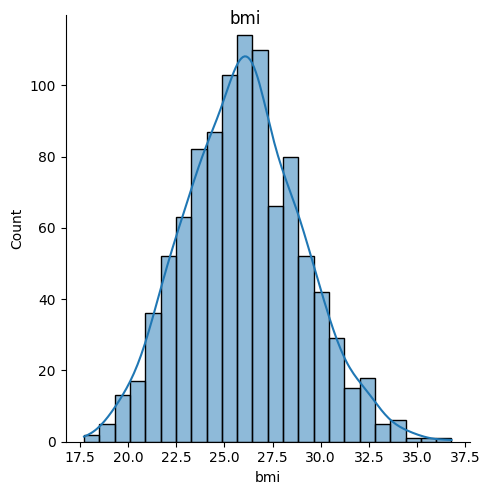

smoker


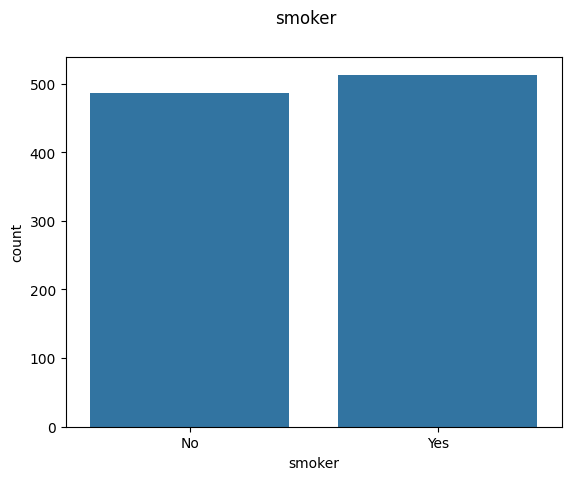

alcohol_consumption


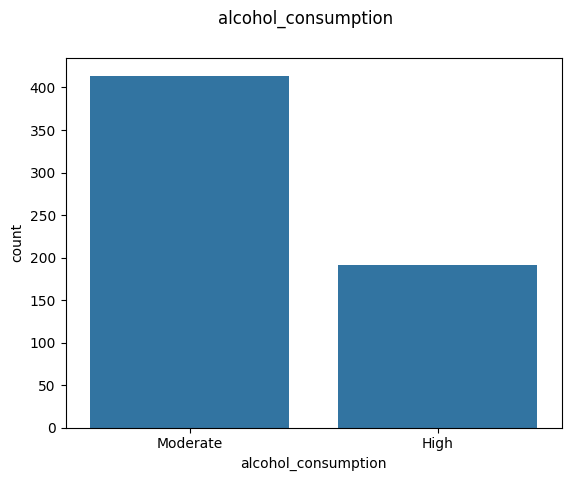

diet_type


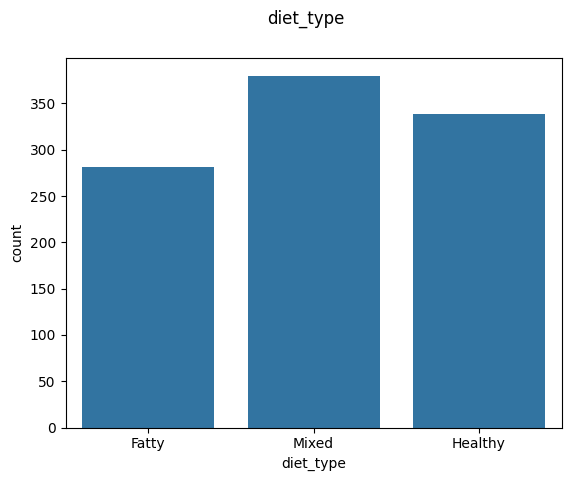

physical_activity_level


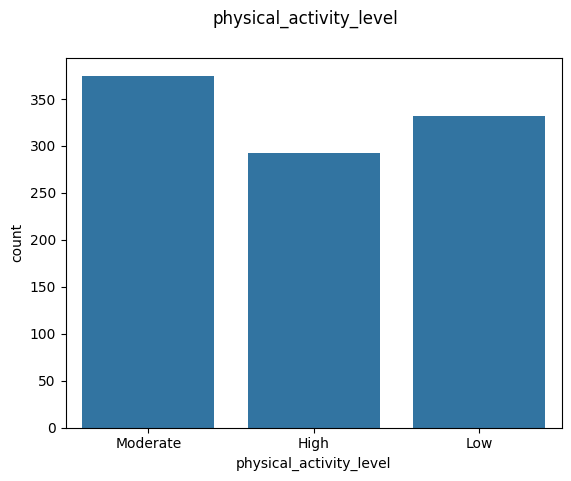

family_history


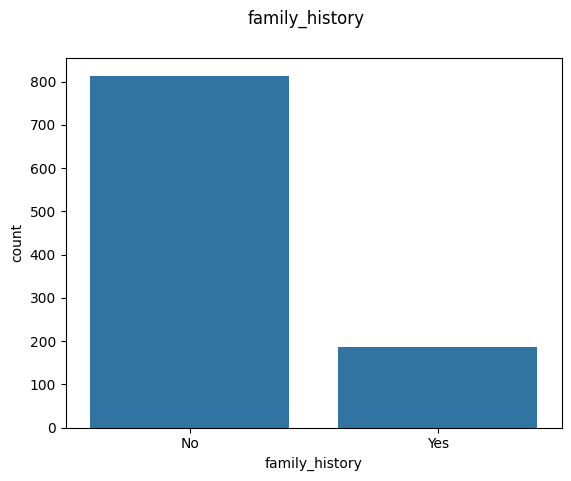

mental_stress_level


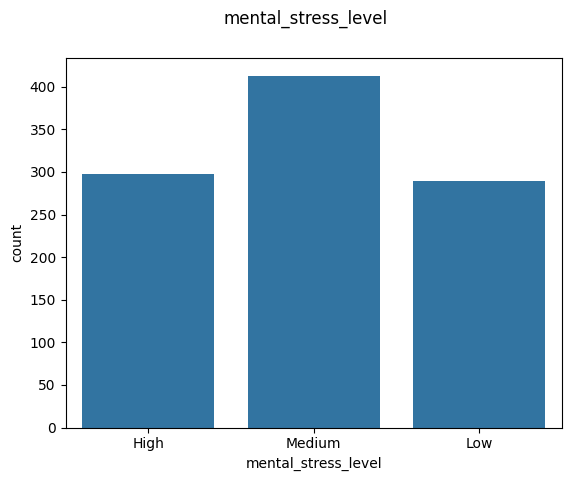

<Figure size 640x480 with 0 Axes>

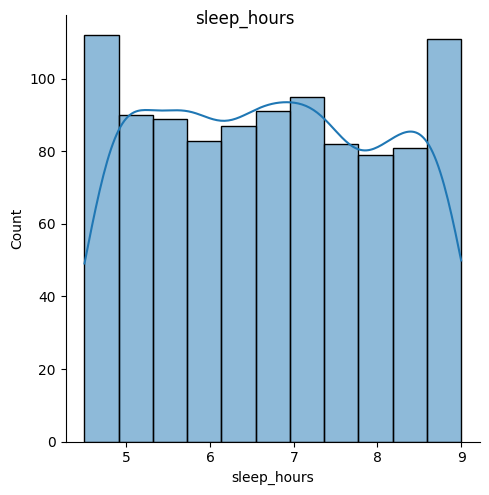

regular_health_checkup


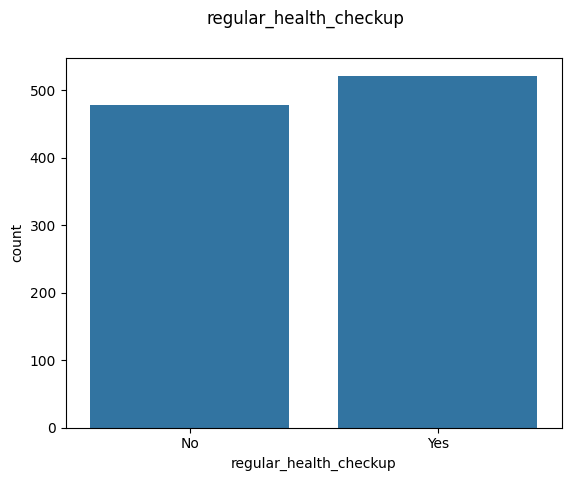

prostate_exam_done


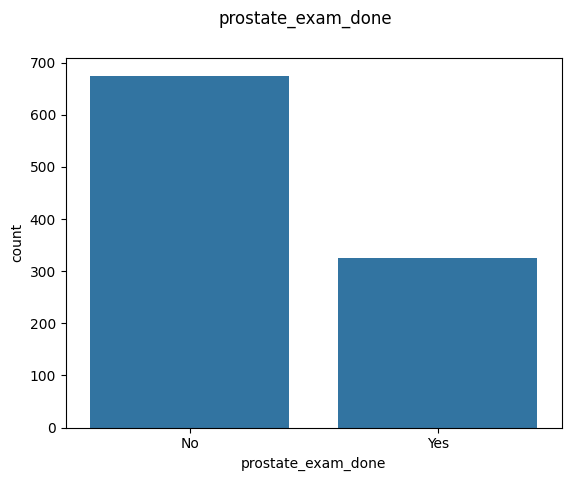

risk_level


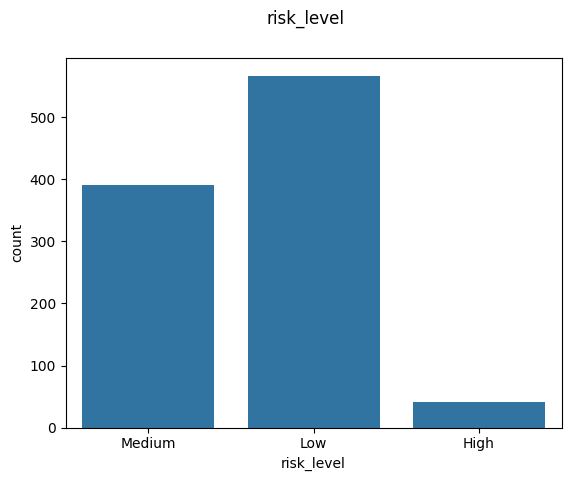

id                           int64
age                          int64
bmi                        float64
smoker                        int8
alcohol_consumption           int8
diet_type                     int8
physical_activity_level       int8
family_history                int8
mental_stress_level           int8
sleep_hours                float64
regular_health_checkup        int8
prostate_exam_done            int8
risk_level                    int8
dtype: object


In [5]:
# Preprocessing/EDA
numerical_df = df[['id', 'age', 'bmi', 'sleep_hours']]
categorical_cols = []
for col in df.columns:
    if col in numerical_df:
        if col == 'id':
            continue
        plt.figure()
        sns.displot(numerical_df[col], kde=True)
        plt.suptitle(col)
        plt.show()
    else:
        categorical_cols.append(col)
        print(col)
        plt.figure()
        plt.suptitle(col)
        sns.countplot(x=col, data=df)
        plt.show()

df_encoded = df.copy()
# Encoding categorical variables
for column in categorical_cols:
    df_encoded[column] = df_encoded[column].astype('category')
    df_encoded[column] = df_encoded[column].cat.codes
print(df_encoded.dtypes)
target = 'risk_level'
Y_encoded = df_encoded[target]
X_encoded = df_encoded.drop(columns=['id', target])

In [9]:
# Initial Training of XGBoost model

mlflow.xgboost.autolog()

with mlflow.start_run():
    X_train, X_val, Y_train, Y_val = train_test_split(X_encoded, Y_encoded)

    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'seed': 42,
        'n_estimators': 1000,
        'early_stopping_rounds': 20,
        'eval_metric': 'mlogloss'
        }
    
    model = xgb.XGBClassifier(**params)
    
    model.fit(
        X_train,
        Y_train, 
        eval_set=[(X_val, Y_val), (X_train, Y_train)]
        )
    
    Y_pred_proba = model.predict_proba(X_val)
    logloss = sklearn.metrics.log_loss(Y_val, Y_pred_proba)

    mlflow.set_tag('model_type', 'xgboost')

[0]	validation_0-mlogloss:1.03038	validation_1-mlogloss:1.00578
[1]	validation_0-mlogloss:0.97500	validation_1-mlogloss:0.92707
[2]	validation_0-mlogloss:0.92786	validation_1-mlogloss:0.85837
[3]	validation_0-mlogloss:0.88568	validation_1-mlogloss:0.79884
[4]	validation_0-mlogloss:0.84243	validation_1-mlogloss:0.74370
[5]	validation_0-mlogloss:0.80522	validation_1-mlogloss:0.69463
[6]	validation_0-mlogloss:0.77105	validation_1-mlogloss:0.65027
[7]	validation_0-mlogloss:0.74134	validation_1-mlogloss:0.60959
[8]	validation_0-mlogloss:0.71525	validation_1-mlogloss:0.57364
[9]	validation_0-mlogloss:0.69132	validation_1-mlogloss:0.54045
[10]	validation_0-mlogloss:0.66827	validation_1-mlogloss:0.50976
[11]	validation_0-mlogloss:0.65047	validation_1-mlogloss:0.48322
[12]	validation_0-mlogloss:0.63366	validation_1-mlogloss:0.45607
[13]	validation_0-mlogloss:0.62086	validation_1-mlogloss:0.43320
[14]	validation_0-mlogloss:0.60682	validation_1-mlogloss:0.40925
[15]	validation_0-mlogloss:0.59338	

2025/07/28 06:10:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/28 06:10:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/28 06:10:58 

In [10]:
def objective(params):
    mlflow.xgboost.autolog()

    with mlflow.start_run():
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train,
            Y_train,
            eval_set=[(X_val, Y_val)]
            )
        Y_pred_proba = model.predict_proba(X_val)
        logloss = sklearn.metrics.log_loss(Y_val, Y_pred_proba)
        
    return {'loss': logloss, 'status': STATUS_OK}


In [11]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),
    'gamma': hp.loguniform('gamma', -3, 1),
    'min_child_weight': hp.loguniform('min_child_weight', 0, 3.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'objective': 'multi:softprob',
    'seed': 42
}
opt_params = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest,
    max_evals=50, 
    trials=Trials())

[0]	validation_0-mlogloss:1.09287                     
[1]	validation_0-mlogloss:1.08778                     
[2]	validation_0-mlogloss:1.08137                     
[3]	validation_0-mlogloss:1.07604                     
[4]	validation_0-mlogloss:1.07080                     
[5]	validation_0-mlogloss:1.06549                     
[6]	validation_0-mlogloss:1.05996                     
[7]	validation_0-mlogloss:1.05458                     
[8]	validation_0-mlogloss:1.04967                     
[9]	validation_0-mlogloss:1.04517                     
[10]	validation_0-mlogloss:1.03962                    
[11]	validation_0-mlogloss:1.03427                    
[12]	validation_0-mlogloss:1.02984                    
[13]	validation_0-mlogloss:1.02518                    
[14]	validation_0-mlogloss:1.02046                    
[15]	validation_0-mlogloss:1.01533                    
[16]	validation_0-mlogloss:1.01070                    
[17]	validation_0-mlogloss:1.00661                    
[18]	valid

[84]	validation_0-mlogloss:0.79664
[85]	validation_0-mlogloss:0.79417                    
[86]	validation_0-mlogloss:0.79213                    
[87]	validation_0-mlogloss:0.78974                    
[88]	validation_0-mlogloss:0.78744                    
[89]	validation_0-mlogloss:0.78520                    
[90]	validation_0-mlogloss:0.78336                    
[91]	validation_0-mlogloss:0.78161                    
[92]	validation_0-mlogloss:0.77973                    
[93]	validation_0-mlogloss:0.77763                    
[94]	validation_0-mlogloss:0.77584                    
[95]	validation_0-mlogloss:0.77365                    
[96]	validation_0-mlogloss:0.77172                    
[97]	validation_0-mlogloss:0.76970                    
[98]	validation_0-mlogloss:0.76791                    
[99]	validation_0-mlogloss:0.76620                    
  0%|          | 0/50 [00:01<?, ?trial/s, best loss=?]

2025/07/28 06:11:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:2

[0]	validation_0-mlogloss:1.09199                                               
[1]	validation_0-mlogloss:1.08636                                               
[2]	validation_0-mlogloss:1.07854                                               
[3]	validation_0-mlogloss:1.07076                                               
[4]	validation_0-mlogloss:1.06360                                               
[5]	validation_0-mlogloss:1.05722                                               
[6]	validation_0-mlogloss:1.05039                                               
[7]	validation_0-mlogloss:1.04389                                               
[8]	validation_0-mlogloss:1.03806                                               
[9]	validation_0-mlogloss:1.03195                                               
[10]	validation_0-mlogloss:1.02491                                              
[11]	validation_0-mlogloss:1.01808                                              
[12]	validation_0-mlogloss:1

2025/07/28 06:11:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:2

[0]	validation_0-mlogloss:1.08053                                               
[1]	validation_0-mlogloss:1.06405                                               
[2]	validation_0-mlogloss:1.04689                                               
[3]	validation_0-mlogloss:1.02965                                               
[4]	validation_0-mlogloss:1.01326                                               
[5]	validation_0-mlogloss:0.99979                                               
[6]	validation_0-mlogloss:0.98392                                               
[7]	validation_0-mlogloss:0.97011                                               
[8]	validation_0-mlogloss:0.95570                                               
[9]	validation_0-mlogloss:0.94216                                               
[10]	validation_0-mlogloss:0.92894                                              
[11]	validation_0-mlogloss:0.91621                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:11:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:3

[0]	validation_0-mlogloss:1.00699                                               
[1]	validation_0-mlogloss:0.94922                                               
[2]	validation_0-mlogloss:0.88788                                               
[3]	validation_0-mlogloss:0.83714                                               
[4]	validation_0-mlogloss:0.80250                                               
[5]	validation_0-mlogloss:0.76888                                               
[6]	validation_0-mlogloss:0.74287                                               
[7]	validation_0-mlogloss:0.72012                                               
[8]	validation_0-mlogloss:0.69928                                               
[9]	validation_0-mlogloss:0.68150                                               
[10]	validation_0-mlogloss:0.66535                                              
[11]	validation_0-mlogloss:0.65157                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:11:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:3

[0]	validation_0-mlogloss:1.00924                                                
[1]	validation_0-mlogloss:0.93493                                                
[2]	validation_0-mlogloss:0.87016                                                
[3]	validation_0-mlogloss:0.81877                                                
[4]	validation_0-mlogloss:0.76946                                                
[5]	validation_0-mlogloss:0.73731                                                
[6]	validation_0-mlogloss:0.70315                                                
[7]	validation_0-mlogloss:0.67219                                                
[8]	validation_0-mlogloss:0.64563                                                
[9]	validation_0-mlogloss:0.62566                                                
[10]	validation_0-mlogloss:0.60930                                               
[11]	validation_0-mlogloss:0.58803                                               
[12]	validation_

2025/07/28 06:11:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:4

[0]	validation_0-mlogloss:1.09402                                                
[1]	validation_0-mlogloss:1.08956                                               
[2]	validation_0-mlogloss:1.08439                                               
[3]	validation_0-mlogloss:1.07924                                               
[4]	validation_0-mlogloss:1.07488                                               
[5]	validation_0-mlogloss:1.07044                                               
[6]	validation_0-mlogloss:1.06582                                               
[7]	validation_0-mlogloss:1.06133                                               
[8]	validation_0-mlogloss:1.05726                                               
[9]	validation_0-mlogloss:1.05296                                               
[10]	validation_0-mlogloss:1.04847                                              
[11]	validation_0-mlogloss:1.04406                                              
[12]	validation_0-mlogloss:

2025/07/28 06:11:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:4

[0]	validation_0-mlogloss:1.09477                                               
[1]	validation_0-mlogloss:1.09085                                               
[2]	validation_0-mlogloss:1.08647                                               
[3]	validation_0-mlogloss:1.08201                                               
[4]	validation_0-mlogloss:1.07791                                               
[5]	validation_0-mlogloss:1.07400                                               
[6]	validation_0-mlogloss:1.06975                                               
[7]	validation_0-mlogloss:1.06600                                               
[8]	validation_0-mlogloss:1.06200                                               
[9]	validation_0-mlogloss:1.05814                                               
[10]	validation_0-mlogloss:1.05413                                              
[11]	validation_0-mlogloss:1.05027                                              
[12]	validation_0-mlogloss:1

2025/07/28 06:11:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:5

[0]	validation_0-mlogloss:1.09114                                               
[1]	validation_0-mlogloss:1.08385                                               
[2]	validation_0-mlogloss:1.07567                                               
[3]	validation_0-mlogloss:1.06725                                               
[4]	validation_0-mlogloss:1.05969                                               
[5]	validation_0-mlogloss:1.05233                                               
[6]	validation_0-mlogloss:1.04411                                               
[7]	validation_0-mlogloss:1.03666                                               
[8]	validation_0-mlogloss:1.02960                                               
[9]	validation_0-mlogloss:1.02243                                               
[10]	validation_0-mlogloss:1.01525                                              
[11]	validation_0-mlogloss:1.00839                                              
[12]	validation_0-mlogloss:1

2025/07/28 06:11:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:11:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:11:5

[0]	validation_0-mlogloss:1.07375                                               
[1]	validation_0-mlogloss:1.05210                                               
[2]	validation_0-mlogloss:1.02753                                               
[3]	validation_0-mlogloss:1.00667                                               
[4]	validation_0-mlogloss:0.98528                                               
[5]	validation_0-mlogloss:0.96830                                               
[6]	validation_0-mlogloss:0.95129                                               
[7]	validation_0-mlogloss:0.93322                                               
[8]	validation_0-mlogloss:0.91560                                               
[9]	validation_0-mlogloss:0.90106                                               
[10]	validation_0-mlogloss:0.88604                                              
[11]	validation_0-mlogloss:0.87163                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:12:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:0

[0]	validation_0-mlogloss:1.09186                                               
[1]	validation_0-mlogloss:1.08563                                               
[2]	validation_0-mlogloss:1.07832                                               
[3]	validation_0-mlogloss:1.07132                                               
[4]	validation_0-mlogloss:1.06439                                               
[5]	validation_0-mlogloss:1.05837                                               
[6]	validation_0-mlogloss:1.05128                                               
[7]	validation_0-mlogloss:1.04506                                               
[8]	validation_0-mlogloss:1.03841                                               
[9]	validation_0-mlogloss:1.03210                                               
[10]	validation_0-mlogloss:1.02558                                              
[11]	validation_0-mlogloss:1.01897                                              
[12]	validation_0-mlogloss:1

2025/07/28 06:12:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:0

[0]	validation_0-mlogloss:0.97244                                                
[1]	validation_0-mlogloss:0.88202                                                
[2]	validation_0-mlogloss:0.80136                                                
[3]	validation_0-mlogloss:0.74264                                                
[4]	validation_0-mlogloss:0.70225                                                
[5]	validation_0-mlogloss:0.66981                                                
[6]	validation_0-mlogloss:0.63556                                                
[7]	validation_0-mlogloss:0.60271                                                
[8]	validation_0-mlogloss:0.57721                                                
[9]	validation_0-mlogloss:0.55989                                                
[10]	validation_0-mlogloss:0.54728                                               
[11]	validation_0-mlogloss:0.52560                                               
[12]	validation_

2025/07/28 06:12:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:1

[0]	validation_0-mlogloss:1.03226                                                 
[1]	validation_0-mlogloss:0.98013                                                 
[2]	validation_0-mlogloss:0.91975                                                 
[3]	validation_0-mlogloss:0.87950                                                 
[4]	validation_0-mlogloss:0.84679                                                 
[5]	validation_0-mlogloss:0.81953                                                 
[6]	validation_0-mlogloss:0.78507                                                 
[7]	validation_0-mlogloss:0.75930                                                 
[8]	validation_0-mlogloss:0.73226                                                 
[9]	validation_0-mlogloss:0.71424                                                 
[10]	validation_0-mlogloss:0.69233                                                
[11]	validation_0-mlogloss:0.67209                                                
[12]

2025/07/28 06:12:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:1

[0]	validation_0-mlogloss:1.09092                                                 
[1]	validation_0-mlogloss:1.08395                                                 
[2]	validation_0-mlogloss:1.07550                                                 
[3]	validation_0-mlogloss:1.06790                                                 
[4]	validation_0-mlogloss:1.06021                                                 
[5]	validation_0-mlogloss:1.05344                                                 
[6]	validation_0-mlogloss:1.04562                                                 
[7]	validation_0-mlogloss:1.03883                                                 
[8]	validation_0-mlogloss:1.03174                                                 
[9]	validation_0-mlogloss:1.02502                                                 
[10]	validation_0-mlogloss:1.01805                                                
[11]	validation_0-mlogloss:1.01081                                                
[12]

2025/07/28 06:12:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:2

[0]	validation_0-mlogloss:1.07556                                                 
[1]	validation_0-mlogloss:1.05361                                                 
[2]	validation_0-mlogloss:1.02974                                                 
[3]	validation_0-mlogloss:1.00825                                                 
[4]	validation_0-mlogloss:0.98803                                                 
[5]	validation_0-mlogloss:0.97124                                                 
[6]	validation_0-mlogloss:0.95294                                                 
[7]	validation_0-mlogloss:0.93357                                                 
[8]	validation_0-mlogloss:0.91579                                                 
[9]	validation_0-mlogloss:0.89912                                                 
[10]	validation_0-mlogloss:0.88269                                                
[11]	validation_0-mlogloss:0.86883                                                
[12]

2025/07/28 06:12:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:2

[0]	validation_0-mlogloss:1.09362                                                 
[1]	validation_0-mlogloss:1.08895                                                 
[2]	validation_0-mlogloss:1.08314                                                 
[3]	validation_0-mlogloss:1.07774                                                 
[4]	validation_0-mlogloss:1.07257                                                 
[5]	validation_0-mlogloss:1.06788                                                 
[6]	validation_0-mlogloss:1.06263                                                 
[7]	validation_0-mlogloss:1.05785                                                 
[8]	validation_0-mlogloss:1.05256                                                 
[9]	validation_0-mlogloss:1.04777                                                 
[10]	validation_0-mlogloss:1.04272                                                
[11]	validation_0-mlogloss:1.03748                                                
[12]

2025/07/28 06:12:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:2

[0]	validation_0-mlogloss:1.08865                                                 
[1]	validation_0-mlogloss:1.07869                                                 
[2]	validation_0-mlogloss:1.06848                                                 
[3]	validation_0-mlogloss:1.05874                                                 
[4]	validation_0-mlogloss:1.04947                                                 
[5]	validation_0-mlogloss:1.04125                                                 
[6]	validation_0-mlogloss:1.03227                                                 
[7]	validation_0-mlogloss:1.02323                                                 
[8]	validation_0-mlogloss:1.01497                                                 
[9]	validation_0-mlogloss:1.00694                                                 
[10]	validation_0-mlogloss:0.99861                                                
[11]	validation_0-mlogloss:0.99046                                                
[12]

2025/07/28 06:12:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:3

[0]	validation_0-mlogloss:1.09045                                                 
[1]	validation_0-mlogloss:1.08375                                                 
[2]	validation_0-mlogloss:1.07559                                                 
[3]	validation_0-mlogloss:1.06747                                                 
[4]	validation_0-mlogloss:1.06017                                                 
[5]	validation_0-mlogloss:1.05308                                                 
[6]	validation_0-mlogloss:1.04541                                                 
[7]	validation_0-mlogloss:1.03825                                                 
[8]	validation_0-mlogloss:1.03136                                                 
[9]	validation_0-mlogloss:1.02434                                                 
[10]	validation_0-mlogloss:1.01713                                                
[11]	validation_0-mlogloss:1.00988                                                
[12]

2025/07/28 06:12:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:3

[0]	validation_0-mlogloss:1.08246                                                 
[1]	validation_0-mlogloss:1.06848                                                 
[2]	validation_0-mlogloss:1.05110                                                 
[3]	validation_0-mlogloss:1.03470                                                 
[4]	validation_0-mlogloss:1.02053                                                 
[5]	validation_0-mlogloss:1.00697                                                 
[6]	validation_0-mlogloss:0.99257                                                 
[7]	validation_0-mlogloss:0.97981                                                 
[8]	validation_0-mlogloss:0.96664                                                 
[9]	validation_0-mlogloss:0.95403                                                 
[10]	validation_0-mlogloss:0.94159                                                
[11]	validation_0-mlogloss:0.92941                                                
[12]

2025/07/28 06:12:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:4

[0]	validation_0-mlogloss:1.09490                                                 
[1]	validation_0-mlogloss:1.09192                                                 
[2]	validation_0-mlogloss:1.08815                                                 
[3]	validation_0-mlogloss:1.08439                                                 
[4]	validation_0-mlogloss:1.08099                                                 
[5]	validation_0-mlogloss:1.07750                                                 
[6]	validation_0-mlogloss:1.07396                                                 
[7]	validation_0-mlogloss:1.07056                                                 
[8]	validation_0-mlogloss:1.06711                                                 
[9]	validation_0-mlogloss:1.06355                                                 
[10]	validation_0-mlogloss:1.05993                                                
[11]	validation_0-mlogloss:1.05666                                                
[12]

2025/07/28 06:12:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:4

[0]	validation_0-mlogloss:1.07005                                                 
[1]	validation_0-mlogloss:1.04357                                                 
[2]	validation_0-mlogloss:1.01699                                                 
[3]	validation_0-mlogloss:0.99353                                                 
[4]	validation_0-mlogloss:0.97207                                                 
[5]	validation_0-mlogloss:0.95287                                                 
[6]	validation_0-mlogloss:0.93254                                                 
[7]	validation_0-mlogloss:0.91383                                                 
[8]	validation_0-mlogloss:0.89645                                                 
[9]	validation_0-mlogloss:0.88088                                                 
[10]	validation_0-mlogloss:0.86516                                                
[11]	validation_0-mlogloss:0.84895                                                
[12]

2025/07/28 06:12:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:5

[0]	validation_0-mlogloss:0.92094                                                 
[1]	validation_0-mlogloss:0.81430                                                 
[2]	validation_0-mlogloss:0.72295                                                 
[3]	validation_0-mlogloss:0.65814                                                 
[4]	validation_0-mlogloss:0.61617                                                 
[5]	validation_0-mlogloss:0.58298                                                 
[6]	validation_0-mlogloss:0.55186                                                 
[7]	validation_0-mlogloss:0.52620                                                 
[8]	validation_0-mlogloss:0.50812                                                 
[9]	validation_0-mlogloss:0.49481                                                 
[10]	validation_0-mlogloss:0.48348                                                
[11]	validation_0-mlogloss:0.45487                                                
[12]

2025/07/28 06:12:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:5

[0]	validation_0-mlogloss:0.93878                                                 
[1]	validation_0-mlogloss:0.84152                                                 
[2]	validation_0-mlogloss:0.75057                                                 
[3]	validation_0-mlogloss:0.68905                                                 
[4]	validation_0-mlogloss:0.64830                                                 
[5]	validation_0-mlogloss:0.61254                                                 
[6]	validation_0-mlogloss:0.57709                                                 
[7]	validation_0-mlogloss:0.55666                                                 
[8]	validation_0-mlogloss:0.53352                                                 
[9]	validation_0-mlogloss:0.52216                                                 
[10]	validation_0-mlogloss:0.50481                                                
[11]	validation_0-mlogloss:0.48146                                                
[12]

2025/07/28 06:12:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:12:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:12:5

[0]	validation_0-mlogloss:0.94173                                                 
[1]	validation_0-mlogloss:0.84246                                                 
[2]	validation_0-mlogloss:0.74785                                                 
[3]	validation_0-mlogloss:0.68663                                                 
[4]	validation_0-mlogloss:0.63632                                                 
[5]	validation_0-mlogloss:0.60403                                                 
[6]	validation_0-mlogloss:0.57065                                                 
[7]	validation_0-mlogloss:0.54477                                                 
[8]	validation_0-mlogloss:0.52034                                                 
[9]	validation_0-mlogloss:0.50836                                                 
[10]	validation_0-mlogloss:0.50059                                                
[11]	validation_0-mlogloss:0.47834                                                
[12]

2025/07/28 06:13:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:0

[0]	validation_0-mlogloss:1.04818                                                 
[1]	validation_0-mlogloss:1.00365                                                 
[2]	validation_0-mlogloss:0.95487                                                 
[3]	validation_0-mlogloss:0.91458                                                 
[4]	validation_0-mlogloss:0.88004                                                 
[5]	validation_0-mlogloss:0.85403                                                 
[6]	validation_0-mlogloss:0.82581                                                 
[7]	validation_0-mlogloss:0.80108                                                 
[8]	validation_0-mlogloss:0.77614                                                 
[9]	validation_0-mlogloss:0.75777                                                 
[10]	validation_0-mlogloss:0.73733                                                
[11]	validation_0-mlogloss:0.71820                                                
[12]

2025/07/28 06:13:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:0

[0]	validation_0-mlogloss:0.92400                                                 
[1]	validation_0-mlogloss:0.80975                                                 
[2]	validation_0-mlogloss:0.71113                                                 
[3]	validation_0-mlogloss:0.63246                                                 
[4]	validation_0-mlogloss:0.58037                                                 
[5]	validation_0-mlogloss:0.54970                                                 
[6]	validation_0-mlogloss:0.52027                                                 
[7]	validation_0-mlogloss:0.49972                                                 
[8]	validation_0-mlogloss:0.48065                                                 
[9]	validation_0-mlogloss:0.45869                                                 
[10]	validation_0-mlogloss:0.44659                                                
[11]	validation_0-mlogloss:0.42676                                                
[12]

2025/07/28 06:13:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:1

[0]	validation_0-mlogloss:1.03856                                                 
[1]	validation_0-mlogloss:0.99210                                                 
[2]	validation_0-mlogloss:0.94051                                                 
[3]	validation_0-mlogloss:0.89757                                                 
[4]	validation_0-mlogloss:0.85907                                                 
[5]	validation_0-mlogloss:0.82687                                                 
[6]	validation_0-mlogloss:0.79452                                                 
[7]	validation_0-mlogloss:0.76851                                                 
[8]	validation_0-mlogloss:0.74129                                                 
[9]	validation_0-mlogloss:0.72166                                                 
[10]	validation_0-mlogloss:0.69982                                                
[11]	validation_0-mlogloss:0.67891                                                
[12]

2025/07/28 06:13:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:1

[0]	validation_0-mlogloss:1.06419                                                 
[1]	validation_0-mlogloss:1.03299                                                 
[2]	validation_0-mlogloss:1.00237                                                 
[3]	validation_0-mlogloss:0.97623                                                 
[4]	validation_0-mlogloss:0.95133                                                 
[5]	validation_0-mlogloss:0.93010                                                 
[6]	validation_0-mlogloss:0.90739                                                 
[7]	validation_0-mlogloss:0.88749                                                 
[8]	validation_0-mlogloss:0.86910                                                 
[9]	validation_0-mlogloss:0.85325                                                 
[10]	validation_0-mlogloss:0.83700                                                
[11]	validation_0-mlogloss:0.81882                                                
[12]

2025/07/28 06:13:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:2

[0]	validation_0-mlogloss:0.94598                                                 
[1]	validation_0-mlogloss:0.85529                                                 
[2]	validation_0-mlogloss:0.76903                                                 
[3]	validation_0-mlogloss:0.70872                                                 
[4]	validation_0-mlogloss:0.65769                                                 
[5]	validation_0-mlogloss:0.62106                                                 
[6]	validation_0-mlogloss:0.59162                                                 
[7]	validation_0-mlogloss:0.56448                                                 
[8]	validation_0-mlogloss:0.54677                                                 
[9]	validation_0-mlogloss:0.52811                                                 
[10]	validation_0-mlogloss:0.51082                                                
[11]	validation_0-mlogloss:0.48834                                                
[12]

2025/07/28 06:13:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:2

[0]	validation_0-mlogloss:0.93114                                                 
[1]	validation_0-mlogloss:0.83371                                                 
[2]	validation_0-mlogloss:0.74687                                                 
[3]	validation_0-mlogloss:0.68757                                                 
[4]	validation_0-mlogloss:0.64176                                                 
[5]	validation_0-mlogloss:0.60674                                                 
[6]	validation_0-mlogloss:0.58336                                                 
[7]	validation_0-mlogloss:0.56512                                                 
[8]	validation_0-mlogloss:0.54474                                                 
[9]	validation_0-mlogloss:0.52845                                                 
[10]	validation_0-mlogloss:0.51582                                                
[11]	validation_0-mlogloss:0.49620                                                
[12]

2025/07/28 06:13:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:3

[0]	validation_0-mlogloss:1.02438                                                 
[1]	validation_0-mlogloss:0.96578                                                 
[2]	validation_0-mlogloss:0.90952                                                 
[3]	validation_0-mlogloss:0.86064                                                 
[4]	validation_0-mlogloss:0.82192                                                 
[5]	validation_0-mlogloss:0.79068                                                 
[6]	validation_0-mlogloss:0.75959                                                 
[7]	validation_0-mlogloss:0.73383                                                 
[8]	validation_0-mlogloss:0.70761                                                 
[9]	validation_0-mlogloss:0.69043                                                 
[10]	validation_0-mlogloss:0.67406                                                
[11]	validation_0-mlogloss:0.65022                                                
[12]

2025/07/28 06:13:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:3

[0]	validation_0-mlogloss:1.04312                                                 
[1]	validation_0-mlogloss:0.99933                                                 
[2]	validation_0-mlogloss:0.95317                                                 
[3]	validation_0-mlogloss:0.91725                                                 
[4]	validation_0-mlogloss:0.88276                                                 
[5]	validation_0-mlogloss:0.85495                                                 
[6]	validation_0-mlogloss:0.82996                                                 
[7]	validation_0-mlogloss:0.80044                                                 
[8]	validation_0-mlogloss:0.77210                                                 
[9]	validation_0-mlogloss:0.75252                                                 
[10]	validation_0-mlogloss:0.73236                                                
[11]	validation_0-mlogloss:0.71236                                                
[12]

2025/07/28 06:13:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:3

[0]	validation_0-mlogloss:0.98600                                                 
[1]	validation_0-mlogloss:0.89662                                                 
[2]	validation_0-mlogloss:0.80923                                                 
[3]	validation_0-mlogloss:0.74100                                                 
[4]	validation_0-mlogloss:0.69006                                                 
[5]	validation_0-mlogloss:0.65674                                                 
[6]	validation_0-mlogloss:0.61838                                                 
[7]	validation_0-mlogloss:0.59207                                                 
[8]	validation_0-mlogloss:0.56835                                                 
[9]	validation_0-mlogloss:0.54471                                                 
[10]	validation_0-mlogloss:0.52620                                                
[11]	validation_0-mlogloss:0.50597                                                
[12]

2025/07/28 06:13:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:4

[0]	validation_0-mlogloss:1.08623                                                 
[1]	validation_0-mlogloss:1.07484                                                 
[2]	validation_0-mlogloss:1.06059                                                 
[3]	validation_0-mlogloss:1.04669                                                 
[4]	validation_0-mlogloss:1.03438                                                 
[5]	validation_0-mlogloss:1.02248                                                 
[6]	validation_0-mlogloss:1.01119                                                 
[7]	validation_0-mlogloss:0.99997                                                 
[8]	validation_0-mlogloss:0.98904                                                 
[9]	validation_0-mlogloss:0.97974                                                 
[10]	validation_0-mlogloss:0.96847                                                
[11]	validation_0-mlogloss:0.95793                                                
[12]

2025/07/28 06:13:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:4

[0]	validation_0-mlogloss:0.98994                                                 
[1]	validation_0-mlogloss:0.92139                                                 
[2]	validation_0-mlogloss:0.84611                                                 
[3]	validation_0-mlogloss:0.79324                                                 
[4]	validation_0-mlogloss:0.74818                                                 
[5]	validation_0-mlogloss:0.71586                                                 
[6]	validation_0-mlogloss:0.68192                                                 
[7]	validation_0-mlogloss:0.65437                                                 
[8]	validation_0-mlogloss:0.62821                                                 
[9]	validation_0-mlogloss:0.61263                                                 
[10]	validation_0-mlogloss:0.59239                                                
[11]	validation_0-mlogloss:0.56704                                                
[12]

2025/07/28 06:13:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:5

[0]	validation_0-mlogloss:1.03866                                                 
[1]	validation_0-mlogloss:0.98914                                                 
[2]	validation_0-mlogloss:0.93717                                                 
[3]	validation_0-mlogloss:0.89637                                                 
[4]	validation_0-mlogloss:0.86246                                                 
[5]	validation_0-mlogloss:0.83246                                                 
[6]	validation_0-mlogloss:0.80104                                                 
[7]	validation_0-mlogloss:0.77635                                                 
[8]	validation_0-mlogloss:0.75251                                                 
[9]	validation_0-mlogloss:0.73389                                                 
[10]	validation_0-mlogloss:0.71392                                                
[11]	validation_0-mlogloss:0.69324                                                
[12]

2025/07/28 06:13:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:13:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:13:5

[0]	validation_0-mlogloss:1.06983                                                 
[1]	validation_0-mlogloss:1.04201                                                 
[2]	validation_0-mlogloss:1.01086                                                 
[3]	validation_0-mlogloss:0.98493                                                 
[4]	validation_0-mlogloss:0.96239                                                 
[5]	validation_0-mlogloss:0.94319                                                 
[6]	validation_0-mlogloss:0.92400                                                 
[7]	validation_0-mlogloss:0.90672                                                 
[8]	validation_0-mlogloss:0.88791                                                 
[9]	validation_0-mlogloss:0.87454                                                 
[10]	validation_0-mlogloss:0.85789                                                
[11]	validation_0-mlogloss:0.84187                                                
[12]

2025/07/28 06:14:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:0

[0]	validation_0-mlogloss:0.98893                                                 
[1]	validation_0-mlogloss:0.91266                                                 
[2]	validation_0-mlogloss:0.84039                                                 
[3]	validation_0-mlogloss:0.78450                                                 
[4]	validation_0-mlogloss:0.75036                                                 
[5]	validation_0-mlogloss:0.72087                                                 
[6]	validation_0-mlogloss:0.68452                                                 
[7]	validation_0-mlogloss:0.65534                                                 
[8]	validation_0-mlogloss:0.62799                                                 
[9]	validation_0-mlogloss:0.61341                                                 
[10]	validation_0-mlogloss:0.59418                                                
[11]	validation_0-mlogloss:0.57474                                                
[12]

2025/07/28 06:14:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:0

[0]	validation_0-mlogloss:0.94244                                                 
[1]	validation_0-mlogloss:0.83276                                                 
[2]	validation_0-mlogloss:0.73976                                                 
[3]	validation_0-mlogloss:0.67897                                                 
[4]	validation_0-mlogloss:0.62487                                                 
[5]	validation_0-mlogloss:0.59251                                                 
[6]	validation_0-mlogloss:0.56332                                                 
[7]	validation_0-mlogloss:0.53377                                                 
[8]	validation_0-mlogloss:0.51333                                                 
[9]	validation_0-mlogloss:0.48880                                                 
[10]	validation_0-mlogloss:0.47480                                                
[11]	validation_0-mlogloss:0.45519                                                
[12]

2025/07/28 06:14:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:1

[0]	validation_0-mlogloss:1.00484                                                 
[1]	validation_0-mlogloss:0.93058                                               
[2]	validation_0-mlogloss:0.86240                                               
[3]	validation_0-mlogloss:0.80700                                               
[4]	validation_0-mlogloss:0.76468                                               
[5]	validation_0-mlogloss:0.72768                                               
[6]	validation_0-mlogloss:0.69510                                               
[7]	validation_0-mlogloss:0.66265                                               
[8]	validation_0-mlogloss:0.63397                                               
[9]	validation_0-mlogloss:0.61139                                               
[10]	validation_0-mlogloss:0.58964                                              
[11]	validation_0-mlogloss:0.56839                                              
[12]	validation_0-mlogloss

2025/07/28 06:14:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:1

[0]	validation_0-mlogloss:0.95092                                               
[1]	validation_0-mlogloss:0.84306                                               
[2]	validation_0-mlogloss:0.75216                                               
[3]	validation_0-mlogloss:0.68722                                               
[4]	validation_0-mlogloss:0.63599                                               
[5]	validation_0-mlogloss:0.60414                                               
[6]	validation_0-mlogloss:0.56772                                               
[7]	validation_0-mlogloss:0.53665                                               
[8]	validation_0-mlogloss:0.51534                                               
[9]	validation_0-mlogloss:0.49806                                               
[10]	validation_0-mlogloss:0.47860                                              
[11]	validation_0-mlogloss:0.45889                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:1

[0]	validation_0-mlogloss:1.02092                                               
[1]	validation_0-mlogloss:0.96621                                               
[2]	validation_0-mlogloss:0.90428                                               
[3]	validation_0-mlogloss:0.84600                                               
[4]	validation_0-mlogloss:0.80192                                               
[5]	validation_0-mlogloss:0.76442                                               
[6]	validation_0-mlogloss:0.73513                                               
[7]	validation_0-mlogloss:0.70497                                               
[8]	validation_0-mlogloss:0.68070                                               
[9]	validation_0-mlogloss:0.65731                                               
[10]	validation_0-mlogloss:0.63676                                              
[11]	validation_0-mlogloss:0.61554                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:2

[0]	validation_0-mlogloss:1.02590                                               
[1]	validation_0-mlogloss:0.96614                                               
[2]	validation_0-mlogloss:0.91049                                               
[3]	validation_0-mlogloss:0.86336                                               
[4]	validation_0-mlogloss:0.82193                                               
[5]	validation_0-mlogloss:0.78693                                               
[6]	validation_0-mlogloss:0.75231                                               
[7]	validation_0-mlogloss:0.72142                                               
[8]	validation_0-mlogloss:0.69469                                               
[9]	validation_0-mlogloss:0.67310                                               
[10]	validation_0-mlogloss:0.65094                                              
[11]	validation_0-mlogloss:0.62834                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:2

[0]	validation_0-mlogloss:1.05705                                               
[1]	validation_0-mlogloss:1.01911                                               
[2]	validation_0-mlogloss:0.97993                                               
[3]	validation_0-mlogloss:0.94310                                               
[4]	validation_0-mlogloss:0.91159                                               
[5]	validation_0-mlogloss:0.88472                                               
[6]	validation_0-mlogloss:0.85556                                               
[7]	validation_0-mlogloss:0.82911                                               
[8]	validation_0-mlogloss:0.80572                                               
[9]	validation_0-mlogloss:0.78337                                               
[10]	validation_0-mlogloss:0.76437                                              
[11]	validation_0-mlogloss:0.74499                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:3

[0]	validation_0-mlogloss:0.97962                                               
[1]	validation_0-mlogloss:0.89651                                               
[2]	validation_0-mlogloss:0.81128                                               
[3]	validation_0-mlogloss:0.73758                                               
[4]	validation_0-mlogloss:0.67925                                               
[5]	validation_0-mlogloss:0.64799                                               
[6]	validation_0-mlogloss:0.60171                                               
[7]	validation_0-mlogloss:0.57153                                               
[8]	validation_0-mlogloss:0.55004                                               
[9]	validation_0-mlogloss:0.53161                                               
[10]	validation_0-mlogloss:0.52193                                              
[11]	validation_0-mlogloss:0.50465                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:3

[0]	validation_0-mlogloss:0.93908                                               
[1]	validation_0-mlogloss:0.83428                                               
[2]	validation_0-mlogloss:0.74229                                               
[3]	validation_0-mlogloss:0.67421                                               
[4]	validation_0-mlogloss:0.62126                                               
[5]	validation_0-mlogloss:0.59144                                               
[6]	validation_0-mlogloss:0.55440                                               
[7]	validation_0-mlogloss:0.52599                                               
[8]	validation_0-mlogloss:0.51220                                               
[9]	validation_0-mlogloss:0.49951                                               
[10]	validation_0-mlogloss:0.48628                                              
[11]	validation_0-mlogloss:0.47805                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:4

[0]	validation_0-mlogloss:1.06439                                               
[1]	validation_0-mlogloss:1.03675                                               
[2]	validation_0-mlogloss:1.00357                                               
[3]	validation_0-mlogloss:0.97231                                               
[4]	validation_0-mlogloss:0.94446                                               
[5]	validation_0-mlogloss:0.92039                                               
[6]	validation_0-mlogloss:0.89742                                               
[7]	validation_0-mlogloss:0.87498                                               
[8]	validation_0-mlogloss:0.85418                                               
[9]	validation_0-mlogloss:0.83723                                               
[10]	validation_0-mlogloss:0.81700                                              
[11]	validation_0-mlogloss:0.79814                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:4

[0]	validation_0-mlogloss:1.07670                                               
[1]	validation_0-mlogloss:1.05717                                               
[2]	validation_0-mlogloss:1.03591                                               
[3]	validation_0-mlogloss:1.01486                                               
[4]	validation_0-mlogloss:0.99628                                               
[5]	validation_0-mlogloss:0.98006                                               
[6]	validation_0-mlogloss:0.96195                                               
[7]	validation_0-mlogloss:0.94540                                               
[8]	validation_0-mlogloss:0.92941                                               
[9]	validation_0-mlogloss:0.91452                                               
[10]	validation_0-mlogloss:0.89971                                              
[11]	validation_0-mlogloss:0.88548                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:4

[0]	validation_0-mlogloss:1.08508                                               
[1]	validation_0-mlogloss:1.07178                                               
[2]	validation_0-mlogloss:1.05856                                               
[3]	validation_0-mlogloss:1.04542                                               
[4]	validation_0-mlogloss:1.03363                                               
[5]	validation_0-mlogloss:1.02230                                               
[6]	validation_0-mlogloss:1.01088                                               
[7]	validation_0-mlogloss:0.99944                                               
[8]	validation_0-mlogloss:0.98805                                               
[9]	validation_0-mlogloss:0.97793                                               
[10]	validation_0-mlogloss:0.96796                                              
[11]	validation_0-mlogloss:0.95768                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:5

[0]	validation_0-mlogloss:1.08883                                               
[1]	validation_0-mlogloss:1.07932                                               
[2]	validation_0-mlogloss:1.06906                                               
[3]	validation_0-mlogloss:1.05902                                               
[4]	validation_0-mlogloss:1.04941                                               
[5]	validation_0-mlogloss:1.04093                                               
[6]	validation_0-mlogloss:1.03221                                               
[7]	validation_0-mlogloss:1.02294                                               
[8]	validation_0-mlogloss:1.01412                                               
[9]	validation_0-mlogloss:1.00595                                               
[10]	validation_0-mlogloss:0.99719                                              
[11]	validation_0-mlogloss:0.98906                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:14:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:14:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:14:5

[0]	validation_0-mlogloss:1.02736                                               
[1]	validation_0-mlogloss:0.96513                                               
[2]	validation_0-mlogloss:0.90540                                               
[3]	validation_0-mlogloss:0.85426                                               
[4]	validation_0-mlogloss:0.80532                                               
[5]	validation_0-mlogloss:0.77249                                               
[6]	validation_0-mlogloss:0.73859                                               
[7]	validation_0-mlogloss:0.70714                                               
[8]	validation_0-mlogloss:0.68190                                               
[9]	validation_0-mlogloss:0.65642                                               
[10]	validation_0-mlogloss:0.63549                                              
[11]	validation_0-mlogloss:0.61354                                              
[12]	validation_0-mlogloss:0

2025/07/28 06:15:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2025/07/28 06:15:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/28 06:15:0

100%|██████████| 50/50 [03:43<00:00,  4.47s/trial, best loss: 0.252752316215377]


In [12]:
print("Best hyperparameters found: ", opt_params)

Best hyperparameters found:  {'colsample_bytree': np.float64(0.9654327653100003), 'gamma': np.float64(0.09972754398000448), 'learning_rate': np.float64(0.30307457280972516), 'max_depth': np.float64(5.0), 'min_child_weight': np.float64(6.657342349944329), 'reg_alpha': np.float64(0.2818997131336645), 'reg_lambda': np.float64(2.305212546264201), 'subsample': np.float64(0.8744382487102669)}


In [13]:
# Optimized model run
with mlflow.start_run():
    mlflow.xgboost.autolog()

    opt_params['max_depth'] = opt_params['max_depth'].astype(int)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        n_estimators=1000,
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        seed=42,
        **opt_params      
    )

    model.fit(
        X_train,
        Y_train,
        eval_set=[(X_val, Y_val), (X_train, Y_train)]
    )

    Y_pred_proba = model.predict_proba(X_val)
    logloss = sklearn.metrics.log_loss(Y_val, Y_pred_proba)

[0]	validation_0-mlogloss:0.94244	validation_1-mlogloss:0.92070
[1]	validation_0-mlogloss:0.83276	validation_1-mlogloss:0.79848
[2]	validation_0-mlogloss:0.73976	validation_1-mlogloss:0.70513
[3]	validation_0-mlogloss:0.67897	validation_1-mlogloss:0.63667
[4]	validation_0-mlogloss:0.62487	validation_1-mlogloss:0.57574
[5]	validation_0-mlogloss:0.59251	validation_1-mlogloss:0.53011
[6]	validation_0-mlogloss:0.56332	validation_1-mlogloss:0.49360
[7]	validation_0-mlogloss:0.53377	validation_1-mlogloss:0.46111
[8]	validation_0-mlogloss:0.51333	validation_1-mlogloss:0.43183
[9]	validation_0-mlogloss:0.48880	validation_1-mlogloss:0.40647
[10]	validation_0-mlogloss:0.47480	validation_1-mlogloss:0.38388
[11]	validation_0-mlogloss:0.45519	validation_1-mlogloss:0.36294
[12]	validation_0-mlogloss:0.44387	validation_1-mlogloss:0.34830
[13]	validation_0-mlogloss:0.43074	validation_1-mlogloss:0.33076
[14]	validation_0-mlogloss:0.41611	validation_1-mlogloss:0.31571
[15]	validation_0-mlogloss:0.40815	

2025/07/28 06:15:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/Assisted-Visual-Navigation/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/28 06:15:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/28 06:15:50 